# Determine Word to PCA Associations

This notebook is designed to run PCA over the document embeddings and calculate category-pca associations with each principal component.

In [1]:
from pathlib import Path
import subprocess

import numpy as np
import pandas as pd
import plotnine as p9
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from tqdm import tqdm_notebook

In [2]:
journal_map_df = (
    pd.read_csv(
        Path("..")
        / Path("exploratory_data_analysis")
        / Path("output/biorxiv_article_metadata.tsv"),
        sep="\t",
    )
    .groupby("doi")
    .agg(
        {
            "doi": "last",
            "document": "first",
            "category": "last",
        }
    )
)
journal_map_df.head()

,doi,document,category
doi,,,
10.1101/000026,10.1101/000026,000026_v1.xml,genetics
10.1101/000042,10.1101/000042,000042_v1.xml,genomics
10.1101/000067,10.1101/000067,000067_v1.xml,genomics
10.1101/000091,10.1101/000091,000091_v1.xml,synthetic biology
10.1101/000109,10.1101/000109,000109_v1.xml,evolutionary biology


# PCA the Documents

Run PCA over the documents. Generates 50 principal components, but can generate more or less.

In [3]:
n_components = 50
random_state = 100

In [5]:
biorxiv_articles_df = pd.read_csv(
    Path("..")
    / Path("word_vector_experiment")
    / Path("output/word2vec_output")
    / Path("biorxiv_all_articles_300.tsv.xz"),
    sep="\t",
)
biorxiv_articles_df = biorxiv_articles_df.dropna()
biorxiv_articles_df.head()

,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,440735_v1.xml,0.063813,0.012187,-0.156229,-0.158987,0.165480,-0.346612,0.001741,-0.107139,0.684055,...,-0.140772,-0.143405,-0.081427,-0.248220,-0.771470,-0.235455,0.547801,0.859663,-0.063151,0.012667
1,775270_v1.xml,-0.201064,0.011870,-0.354809,-0.150633,0.095305,-0.507254,-0.339986,0.303313,0.944561,...,-0.115199,-0.259798,0.272955,-0.346138,-0.844158,-0.596267,0.121678,0.959160,-0.747369,-0.073314
2,242404_v1.xml,-0.204741,-0.107589,-0.062853,0.140793,0.066307,-0.463290,-0.106492,-0.040269,0.557687,...,-0.229839,-0.325765,-0.064586,-0.300529,-0.707948,-0.479390,0.381809,0.968333,-0.402499,-0.109250
3,872994_v1.xml,-0.256990,-0.055972,-0.300816,0.495731,0.290070,-0.310817,-0.481578,-0.161373,0.483896,...,0.148916,-0.217426,0.195183,-0.069086,-0.545689,-0.517949,0.265230,0.645038,-0.843499,-0.142928
4,080853_v2.xml,0.167641,0.046808,-0.709753,0.232242,-0.139213,-0.319284,-0.314807,0.310180,0.317704,...,0.540693,0.264286,0.256323,0.137184,-0.754344,-0.145583,0.032544,0.507430,-0.374320,0.473060


In [6]:
reducer = PCA(n_components=n_components, random_state=random_state)

reducer.fit(biorxiv_articles_df[[f"feat_{idx}" for idx in range(300)]].values)

PCA(n_components=50, random_state=100)

In [7]:
document_categories_df = journal_map_df[["document", "category"]].merge(
    biorxiv_articles_df, on="document"
)
document_categories_df.head()

,document,category,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,000026_v1.xml,genetics,-0.044238,0.042773,-0.131834,-0.002672,0.135241,-0.302512,-0.113688,-0.210036,...,0.066490,-0.173164,-0.102007,-0.046054,-0.858827,-0.619672,0.374192,1.072033,-0.142945,-0.054528
1,000042_v1.xml,genomics,-0.323587,-0.229565,-0.120892,-0.179184,0.084926,-0.467845,-0.091798,0.293254,...,-0.007438,0.053551,0.011887,-0.164012,-0.598107,-0.316184,0.483675,0.748457,-0.338565,0.009289
2,000067_v1.xml,genomics,0.025268,0.164317,-0.095816,-0.145657,-0.006043,-0.322385,-0.037833,0.090648,...,0.170596,-0.111823,0.074954,-0.173614,-0.747070,-0.613020,0.269025,0.582739,-0.374461,0.418433
3,000091_v1.xml,synthetic biology,-0.132056,0.118364,-0.273165,0.298218,0.292788,-0.637130,-0.468698,0.022352,...,0.300299,-0.441953,0.544878,-0.001271,-0.353551,-0.701067,0.296414,0.717840,-0.679277,0.032921
4,000109_v1.xml,evolutionary biology,-0.104861,0.045978,-0.130486,0.098894,0.034303,-0.032209,0.071061,-0.063411,...,0.171565,-0.131917,0.152926,-0.212052,-0.744034,-0.514488,0.123406,0.911272,-0.278870,0.342552


# Bootstrap 95% Confidence Intervals Cosine sim

In [8]:
boostraped_iterations = 10000
pc_1 = []
pc_2 = []

# The for loop performs the following algorithm to estimate 95% confidence intervals:
#
# 1. Group document embeddings by category
# 2. Randomly sample a document from each category
# 3. Calculate the similarity scores between the documents and the first two principal components
# 4. Repeat the above steps for 10000 iterations.
# 5. Finally take the 25th percentile and the 97.5th percentile to make up the interval

for iteration in tqdm_notebook(range(boostraped_iterations)):
    sampled_df = (
        document_categories_df.groupby("category")
        .apply(lambda x: x.sample(1, random_state=iteration))
        .reset_index(drop=True)
        .sort_values("category")
    )

    document_distance = 1 - cdist(
        (sampled_df.drop(["document", "category"], axis=1).values),
        reducer.components_[0:2],
        "cosine",
    )

    pc_1.append(document_distance[:, 0])
    pc_2.append(document_distance[:, 1])

pc_1 = np.stack(pc_1)
pc_2 = np.stack(pc_2)

In [9]:
mean_similarity_df = pd.DataFrame(
    (
        1
        - cdist(
            document_categories_df.drop(["document", "category"], axis=1).values,
            reducer.components_[0:2],
            "cosine",
        )
    ),
    columns=["pca1_cossim", "pca2_cossim"],
).assign(
    category=document_categories_df.category.tolist(),
    document=document_categories_df.document.tolist(),
)
mean_similarity_df.head()

,pca1_cossim,pca2_cossim,category,document
0,0.654437,0.179650,genetics,000026_v1.xml
1,0.671099,0.227241,genomics,000042_v1.xml
2,0.391010,0.319285,genomics,000067_v1.xml
3,0.484460,-0.141946,synthetic biology,000091_v1.xml
4,0.523017,0.234315,evolutionary biology,000109_v1.xml


In [10]:
category_sim_df = (
    mean_similarity_df.groupby("category")
    .agg({"pca1_cossim": "mean", "pca2_cossim": "mean"})
    .assign(
        pca1_cossim_upper=np.percentile(pc_1, 97.5, axis=0),
        pca1_cossim_lower=np.percentile(pc_1, 25, axis=0),
        pca2_cossim_upper=np.percentile(pc_2, 97.5, axis=0),
        pca2_cossim_lower=np.percentile(pc_2, 25, axis=0),
    )
    .reset_index()[
        [
            "category",
            "pca1_cossim_lower",
            "pca1_cossim",
            "pca1_cossim_upper",
            "pca2_cossim_lower",
            "pca2_cossim",
            "pca2_cossim_upper",
        ]
    ]
)
category_sim_df.head()

,category,pca1_cossim_lower,pca1_cossim,pca1_cossim_upper,pca2_cossim_lower,pca2_cossim,pca2_cossim_upper
0,animal behavior and cognition,0.445575,0.513820,0.687542,-0.204662,-0.127012,0.076621
1,biochemistry,0.005238,0.105072,0.471843,-0.018606,0.045348,0.244530
2,bioengineering,0.107463,0.274258,0.641071,-0.173730,-0.073451,0.270746
3,bioinformatics,0.446695,0.503606,0.665350,0.128013,0.206809,0.416983
4,biophysics,0.179743,0.291722,0.580397,-0.154729,-0.076935,0.153746


In [11]:
category_sim_df.to_csv("output/category_cossim_95_ci.tsv", sep="\t", index=False)

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 11 x 7 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/pca_plots/figures/category_pca1_95_ci.svg
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 11 x 7 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/pca_plots/figures/category_pca1_95_ci.png


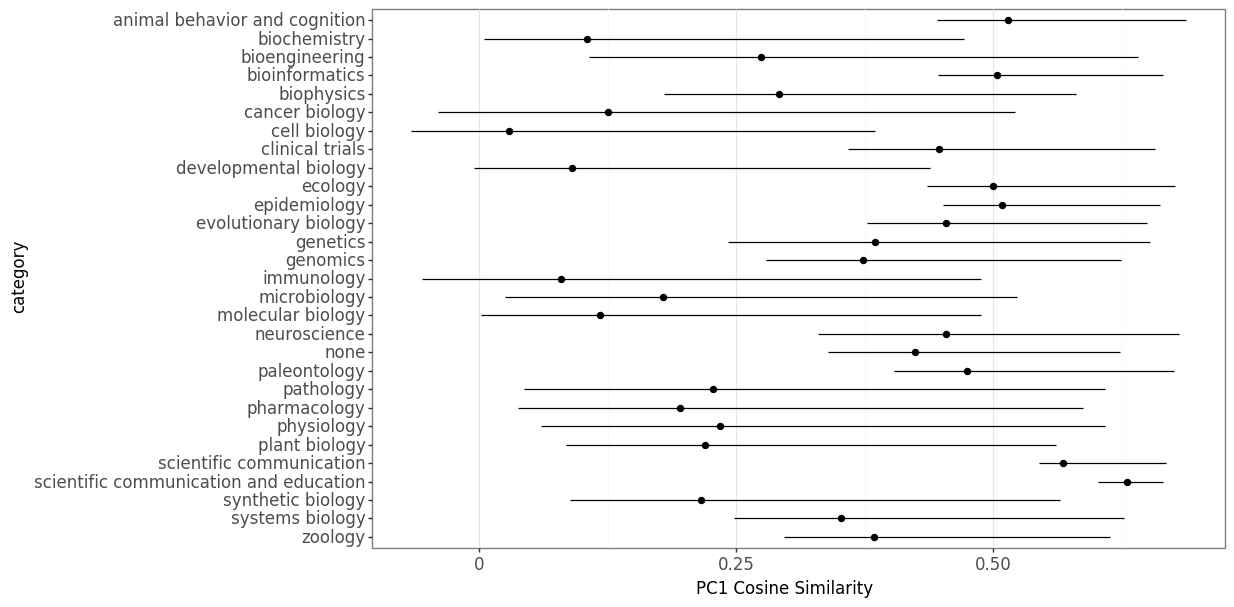

<ggplot: (8734880535756)>


In [12]:
g = (
    p9.ggplot(category_sim_df)
    + p9.aes(
        x="category",
        y="pca1_cossim",
        ymin="pca1_cossim_lower",
        ymax="pca1_cossim_upper",
    )
    + p9.geom_pointrange()
    + p9.coord_flip()
    + p9.theme_bw()
    + p9.scale_x_discrete(limits=category_sim_df.category.tolist()[::-1])
    + p9.theme(
        figure_size=(11, 8.5),
        text=p9.element_text(size=12),
        panel_grid_major_y=p9.element_blank(),
    )
    + p9.labs(y="PC1 Cosine Similarity")
)
g.save("output/pca_plots/figures/category_pca1_95_ci.png", dpi=500)
print(g)

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 11 x 8.5 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/pca_plots/figures/category_pca2_95_ci.svg
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 11 x 8.5 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/pca_plots/figures/category_pca2_95_ci.png


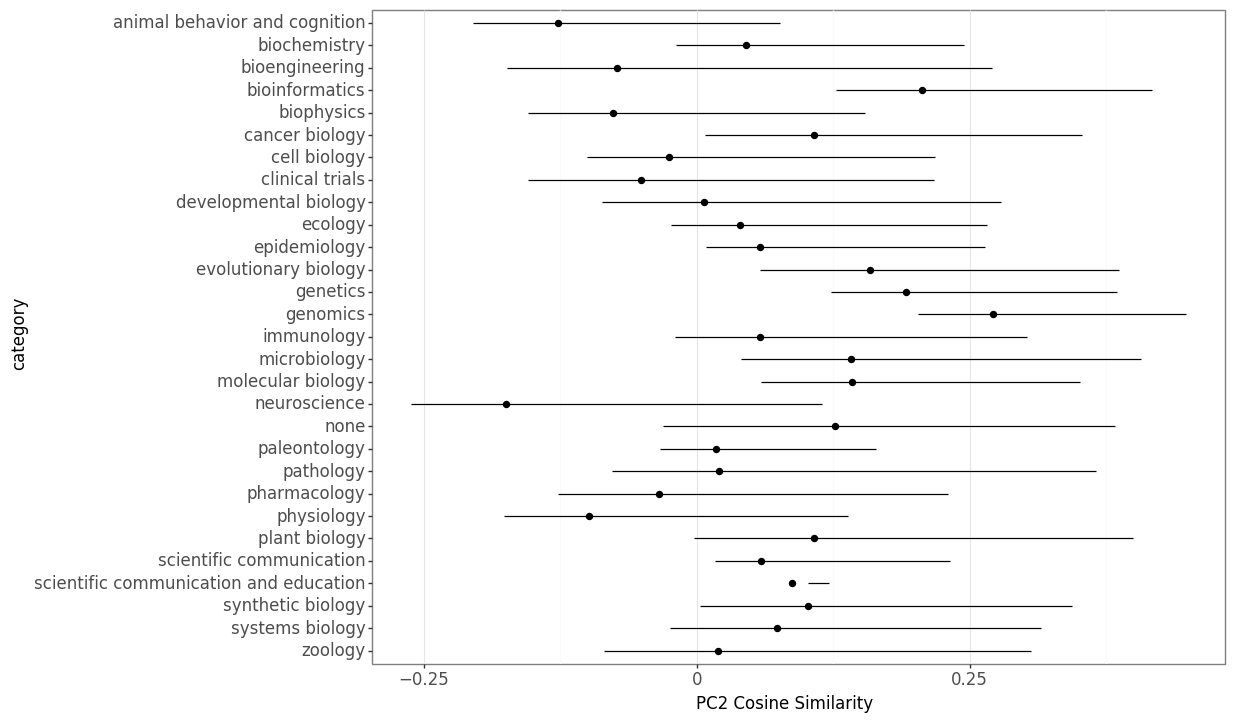

<ggplot: (-9223363301974659433)>


In [13]:
g = (
    p9.ggplot(category_sim_df)
    + p9.aes(
        x="category",
        y="pca2_cossim",
        ymax="pca2_cossim_upper",
        ymin="pca2_cossim_lower",
    )
    + p9.geom_pointrange()
    + p9.coord_flip()
    + p9.theme_bw()
    + p9.scale_x_discrete(limits=category_sim_df.category.tolist()[::-1])
    + p9.theme(
        figure_size=(11, 8.5),
        text=p9.element_text(size=12),
        panel_grid_major_y=p9.element_blank(),
    )
    + p9.labs(y="PC2 Cosine Similarity")
)
g.save("output/pca_plots/figures/category_pca2_95_ci.png", dpi=500)
print(g)

# Plot Documents Projected on PCs Grouped by Category

In [14]:
projected_documents = reducer.transform(
    document_categories_df[[f"feat_{idx}" for idx in range(300)]]
)
projected_documents.shape

(71111, 50)

In [15]:
projected_documents_df = pd.DataFrame(
    projected_documents, columns=[f"PC_{dim+1}" for dim in range(n_components)]
).assign(
    category=document_categories_df.category.tolist(),
    document=document_categories_df.document.tolist(),
)
projected_documents_df

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_43,PC_44,PC_45,PC_46,PC_47,PC_48,PC_49,PC_50,category,document
0,3.100430,1.215363,1.342846,-0.411148,1.260336,-0.868672,0.157510,0.261988,-0.202083,0.286242,...,0.126458,0.041314,-0.174224,0.129338,0.143940,-0.065057,0.006404,0.150397,genetics,000026_v1.xml
1,2.986112,1.552358,0.408195,-0.317189,0.239393,1.895245,0.456889,0.203005,0.648873,0.605436,...,-0.060436,0.094785,-0.216499,-0.042243,0.104961,-0.103863,-0.036405,0.009857,genomics,000042_v1.xml
2,0.340528,2.138809,-0.283082,-0.127782,-0.165013,-1.615413,-0.037500,-0.149159,0.600840,-0.019774,...,0.041944,-0.093093,0.004909,-0.087451,0.028462,-0.032211,0.021938,-0.024871,genomics,000067_v1.xml
3,1.525584,-1.649484,-0.891001,-0.352663,2.111928,0.419450,1.332704,-0.783356,0.477111,-0.817487,...,0.020050,-0.134228,-0.216053,-0.271720,-0.440582,0.138811,-0.064094,0.148674,synthetic biology,000091_v1.xml
4,1.289877,1.421114,0.499253,1.199919,0.623581,-1.689071,-0.769812,0.627031,0.281917,0.363548,...,0.012550,0.140719,0.158759,0.090770,0.148378,-0.108577,-0.009380,-0.062681,evolutionary biology,000109_v1.xml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71106,-2.272131,1.034789,-0.426419,0.182534,0.136948,-0.261429,-0.177199,0.065559,0.256550,0.105641,...,-0.049244,0.183998,-0.044629,-0.025088,-0.254099,-0.212884,-0.002700,-0.130503,cell biology,872853_v1.xml
71107,-2.121839,0.297440,-2.467948,-0.497103,1.569594,0.066935,-1.587045,-1.375796,-0.240700,1.335591,...,0.290298,-0.246558,-0.250806,0.215214,0.213736,-0.083202,0.089744,-0.002119,biochemistry,872879_v1.xml
71108,-3.087386,-0.777913,-0.726873,-0.622268,1.508816,0.102496,0.495238,1.536297,0.713282,0.494914,...,0.199447,-0.021447,-0.011822,0.169655,0.120599,-0.067466,0.228142,0.052267,cell biology,872952_v1.xml
71109,-3.488255,-0.906566,0.771335,-1.293047,-0.274067,-0.037784,0.234464,1.192640,-0.262161,0.009152,...,0.025814,0.073396,-0.176974,-0.057369,-0.027312,0.061794,0.174754,0.223735,developmental biology,873109_v1.xml


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 11 x 8.5 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/pca_plots/figures/category_box_plot_pc1.png
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 11 x 8.5 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/pca_plots/svg_files/category_box_plot/category_box_plot_pc1.svg


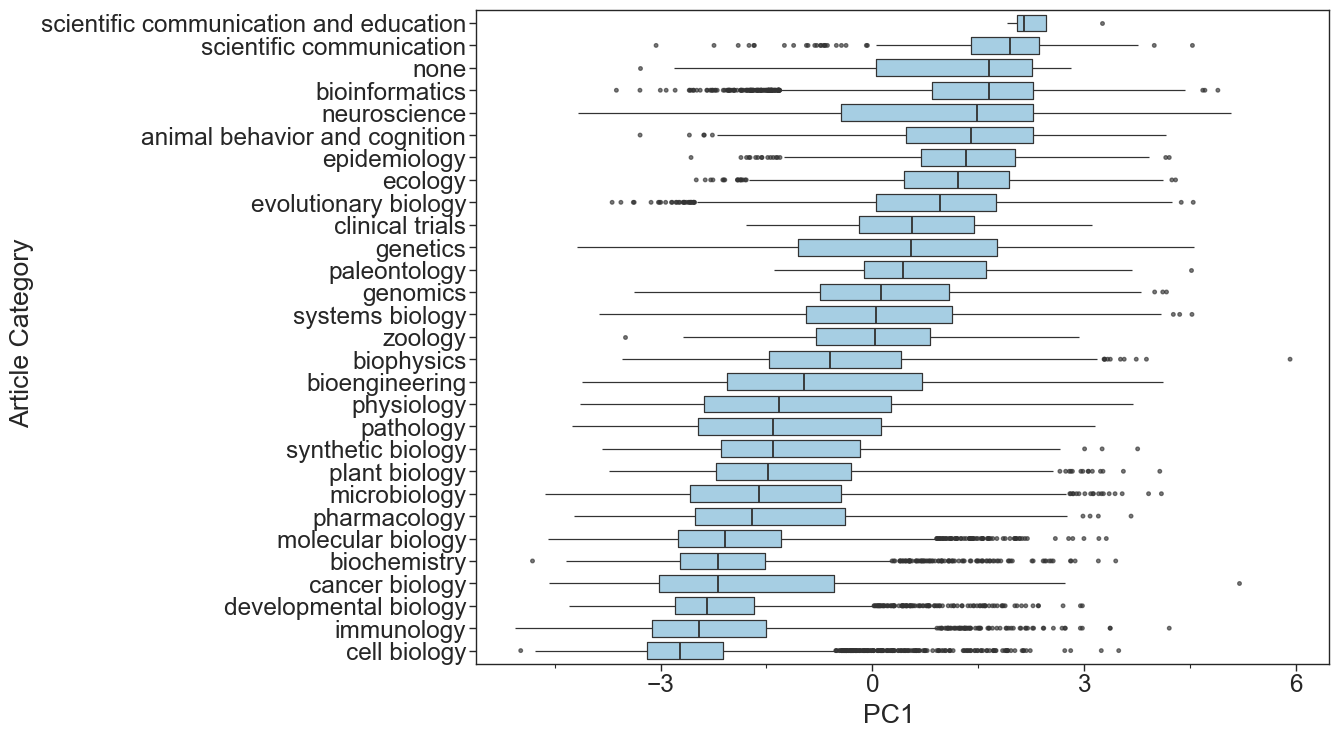

<ggplot: (-9223363301977126305)>


In [18]:
g = (
    p9.ggplot(projected_documents_df)
    + p9.aes(x="factor(category)", y="PC_1")
    + p9.geom_boxplot(
        fill="#a6cee3",
        outlier_size=1,
        outlier_alpha=0.65,
        fatten=1.5,
    )
    + p9.coord_flip()
    + p9.scale_x_discrete(
        limits=(
            projected_documents_df.groupby("category")
            .agg({"PC_1": "median"})
            .sort_values("PC_1", ascending=False)
            .reset_index()
            .category.tolist()[::-1]
        )
    )
    + p9.labs(x="Article Category", y="PC1")
    + p9.theme_seaborn(context="paper", style="ticks", font="Arial", font_scale=2)
    + p9.theme(figure_size=(11, 8.5))
)
g.save("output/pca_plots/figures/category_box_plot_pc1.png", dpi=250)
g.save(
    "output/pca_plots/svg_files/category_box_plot/category_box_plot_pc1.svg", dpi=250
)
print(g)

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 11 x 8.5 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/pca_plots/figures/category_box_plot_pc2.png
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 11 x 8.5 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/pca_plots/svg_files/category_box_plot/category_box_plot_pc2.svg


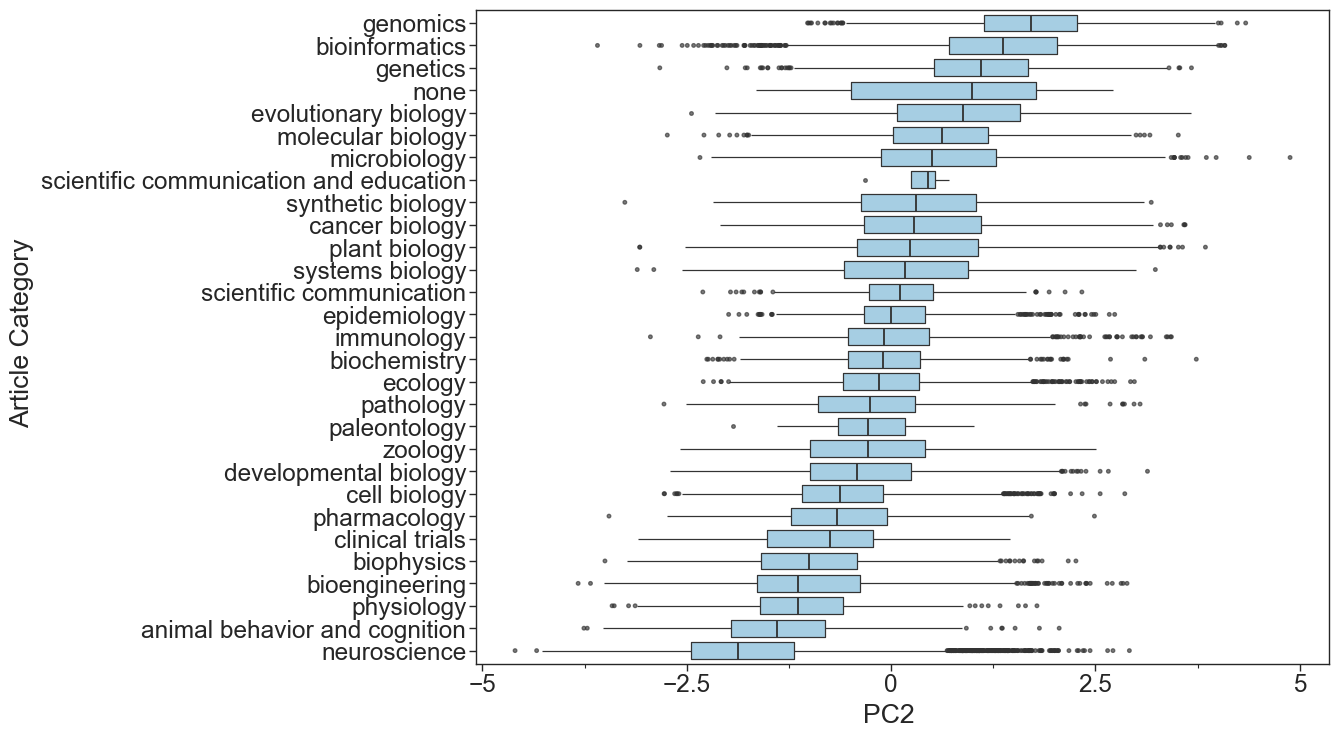

<ggplot: (8734881568211)>


In [19]:
g = (
    p9.ggplot(projected_documents_df)
    + p9.aes(x="factor(category)", y="PC_2")
    + p9.geom_boxplot(
        fill="#a6cee3",
        outlier_size=1,
        outlier_alpha=0.65,
        fatten=1.5,
    )
    + p9.coord_flip()
    + p9.scale_x_discrete(
        limits=(
            projected_documents_df.groupby("category")
            .agg({"PC_2": "median"})
            .sort_values("PC_2", ascending=False)
            .reset_index()
            .category.tolist()[::-1]
        )
    )
    + p9.labs(x="Article Category", y="PC2")
    + p9.theme_seaborn(context="paper", style="ticks", font="Arial", font_scale=2)
    + p9.theme(figure_size=(11, 8.5))
)
g.save("output/pca_plots/figures/category_box_plot_pc2.png", dpi=250)
g.save(
    "output/pca_plots/svg_files/category_box_plot/category_box_plot_pc2.svg", dpi=250
)
print(g)

# Tables with Figures

In [17]:
def dump_figures_and_table(
    table_df, figure_selector, output_path="output/table", column_value="PC_1"
):

    # Output figures to folder
    for idx, row in table_df.iterrows():
        subprocess.Popen(
            [
                "unzip",
                "-j",
                "-o",
                Path("..") / Path(row["hash"]),
                Path("content") / Path(figure_selector[row["document"]]),
                "-d",
                Path("output/table_figures"),
            ]
        )

    # Output table in Manubot format
    # to make incorporating this figure much easier in text
    # http://greenelab.github.io/annorxiver_manuscript
    (
        table_df[["document", "doi", column_value]]
        # doi - a manubot formatted doi link. Manubot creaes citations via [@doi:doi_link]
        # figure - a markdown formmated link to show figure images within a given table.
        .assign(
            doi=lambda x: x.doi.apply(lambda link: f"[@doi:{link}]"),
            figure=lambda x: x.document.apply(
                lambda doc: f"![](table_figures/{document_figure_selector[doc]})"
            ),
        )
        .drop("document", axis=1)
        .to_csv(f"{output_path}.tsv", sep="\t", index=False)
    )

In [18]:
document_hash_df = pd.read_csv("../biorxiv_doc_hash_mapper.tsv", sep="\t")
document_hash_df.head()

,hash,doc_number
0,Back_Content/Batch_37/9053e435-6c1c-1014-ae3b-...,344929_v1.xml
1,Back_Content/Batch_37/7b48c4a4-6c82-1014-86f6-...,337824_v1.xml
2,Back_Content/Batch_37/9022c674-6c41-1014-9caf-...,343640_v1.xml
3,Back_Content/Batch_37/e555f7da-6c1c-1014-8142-...,346395_v1.xml
4,Back_Content/Batch_37/bedf3bbe-6bfd-1014-b91a-...,342253_v1.xml


## Top PC1

In [19]:
# 035014_v1.xml does not have a figure.
# Use replacement document instead
top_pc1_documents = (
    journal_map_df[["document", "doi"]]
    .merge(
        projected_documents_df.query("category=='systems biology'")
        .sort_values("PC_1", ascending=False)
        .head(5),
        on="document",
    )
    .merge(document_hash_df, left_on="document", right_on="doc_number")
)
top_pc1_documents

,document,doi,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,...,PC_44,PC_45,PC_46,PC_47,PC_48,PC_49,PC_50,category,hash,doc_number
0,044818_v1.xml,10.1101/044818,4.079856,0.882982,-1.396013,-1.592699,0.709965,2.216889,1.067835,-0.214281,...,0.029994,0.288929,0.012994,-0.323969,0.237527,-0.143068,-0.161014,systems biology,Back_Content/Batch_05/f9f93e4a-6c04-1014-a553-...,044818_v1.xml
1,107250_v1.xml,10.1101/107250,4.022240,0.806126,-1.903815,-0.145461,-0.328721,1.611151,1.334021,0.093976,...,0.015253,0.247160,-0.164386,-0.417748,-0.187263,-0.085449,-0.060059,systems biology,Back_Content/Batch_13/cd2e8e00-6c08-1014-ac3f-...,107250_v1.xml
2,197400_v1.xml,10.1101/197400,4.522818,0.120427,-1.759847,-0.168677,0.663470,0.780687,2.071695,-0.010277,...,-0.248234,0.110222,-0.035107,-0.015740,-0.162263,-0.129573,-0.083731,systems biology,Back_Content/Batch_22/5ccdf4fe-6c04-1014-9393-...,197400_v1.xml
3,266775_v1.xml,10.1101/266775,4.348957,1.056124,-1.949852,-0.749111,0.490821,1.755982,2.042191,0.207914,...,0.008792,0.401625,-0.058304,-0.479802,-0.032110,-0.175556,-0.172368,systems biology,Back_Content/Batch_30/bcadaeb7-6c0a-1014-ad99-...,266775_v1.xml
4,769299_v1.xml,10.1101/769299,4.259104,0.334061,-1.876578,-0.018297,0.777925,0.706858,1.761776,-0.073429,...,-0.226290,0.247302,0.010015,0.040909,-0.320083,-0.091089,-0.296997,systems biology,Current_Content/September_2019/Batch_#290/e1bb...,769299_v1.xml


In [20]:
document_figure_selector = {
    "044818_v1.xml": "044818_fig1.tif",
    "107250_v1.xml": "107250_fig1.tif",
    "197400_v1.xml": "197400_fig1.tif",
    "769299_v1.xml": "769299v1_fig1.tif",
    "266775_v1.xml": "266775_fig1.tif",
}

In [21]:
dump_figures_and_table(
    top_pc1_documents,
    document_figure_selector,
    output_path="output/tables/top_pc1_table",
    column_value="PC_1",
)

## Bottom PC1

In [22]:
bottom_pc1_documents = (
    journal_map_df[["document", "doi"]]
    .merge(
        projected_documents_df.query("category=='systems biology'")
        .sort_values("PC_1", ascending=True)
        .head(),
        on="document",
    )
    .merge(document_hash_df, left_on="document", right_on="doc_number")
)
bottom_pc1_documents

,document,doi,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,...,PC_44,PC_45,PC_46,PC_47,PC_48,PC_49,PC_50,category,hash,doc_number
0,872887_v1.xml,10.1101/2019.12.11.872887,-3.478380,-0.513607,1.563591,-1.119017,-0.257861,-0.409653,0.087153,-0.846980,...,0.041371,-0.101120,0.045690,0.062663,0.068295,-0.132795,-0.042371,systems biology,Current_Content/December_2019/58f1d5e2-6c01-10...,872887_v1.xml
1,455048_v1.xml,10.1101/455048,-3.728443,-0.164763,0.418169,-1.160511,0.926474,0.577686,0.809683,-0.032513,...,-0.086688,0.103690,0.067724,0.054113,-0.230818,-0.107912,-0.015810,systems biology,Back_Content/Batch_50/94c86cc3-6bfa-1014-a920-...,455048_v1.xml
2,733162_v1.xml,10.1101/733162,-3.736397,-1.073615,0.574679,-0.168391,0.144596,-0.036026,1.607443,-0.708200,...,-0.167689,-0.129839,0.150111,-0.020120,-0.046651,-0.237088,-0.037750,systems biology,Current_Content/August_2019/Batch_#254/3cb22cf...,733162_v1.xml
3,745943_v1.xml,10.1101/745943,-3.692616,-1.001748,1.441111,-0.193869,-1.320587,0.361538,1.164453,-0.497386,...,0.291471,0.001905,-0.006070,0.299779,0.007093,-0.002307,0.037522,systems biology,Current_Content/August_2019/Batch_#269/62b5959...,745943_v1.xml
4,754572_v1.xml,10.1101/754572,-3.876923,-0.356696,0.191259,-0.468034,0.066346,-0.326495,1.656788,-0.071175,...,-0.124760,-0.129042,0.238955,-0.074262,-0.001294,-0.150179,-0.004174,systems biology,Current_Content/September_2019/Batch_#273/8f50...,754572_v1.xml


In [23]:
document_figure_selector = {
    "872887_v1.xml": "872887v1_fig1.tif",
    "455048_v1.xml": "455048_fig1.tif",
    "733162_v1.xml": "733162v1_fig1.tif",
    "745943_v1.xml": "745943v1_fig1.tif",
    "754572_v1.xml": "754572v1_fig1.tif",
}

In [24]:
dump_figures_and_table(
    bottom_pc1_documents,
    document_figure_selector,
    output_path="output/tables/bottom_pc1_table",
    column_value="PC_1",
)

## Top PC2

In [25]:
top_pc2_documents = (
    journal_map_df[["document", "doi"]]
    .merge(
        projected_documents_df.query("category=='systems biology'")
        .sort_values("PC_2", ascending=False)
        .head(),
        on="document",
    )
    .merge(document_hash_df, left_on="document", right_on="doc_number")
)
top_pc2_documents

,document,doi,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,...,PC_44,PC_45,PC_46,PC_47,PC_48,PC_49,PC_50,category,hash,doc_number
0,220152_v1.xml,10.1101/220152,0.943567,2.889125,-0.840985,-1.032858,-0.808014,1.394856,-0.353605,0.253320,...,0.127917,-0.001270,-0.011998,0.042366,-0.049582,-0.168185,-0.128380,systems biology,Back_Content/Batch_25/4b52b43b-6c14-1014-ade0-...,220152_v1.xml
1,328591_v1.xml,10.1101/328591,0.728806,2.992746,-0.483679,-1.396637,-0.034948,1.027755,-0.315478,-0.036996,...,0.068568,0.116136,-0.265341,0.124229,0.041820,0.064702,0.117391,systems biology,Back_Content/Batch_36/49399edf-6c41-1014-9d7a-...,328591_v1.xml
2,484204_v2.xml,10.1101/484204,2.290157,2.884474,0.308020,-0.960670,0.101137,0.156828,-0.018391,-0.171943,...,-0.044159,0.145726,-0.155571,0.282450,0.157828,0.091852,-0.004498,systems biology,Current_Content/April_2019/Batch_#148/247eb1e4...,484204_v2.xml
3,595819_v1.xml,10.1101/595819,1.837344,2.991602,1.512208,-1.037064,-0.554991,1.922637,-0.035211,0.210025,...,0.463052,-0.121319,-0.030141,0.364302,0.283524,0.151400,-0.179126,systems biology,Current_Content/April_2019/Batch_#120/f54dd682...,595819_v1.xml
4,781328_v1.xml,10.1101/781328,0.142721,3.232419,-0.345971,-0.159675,0.281697,0.224584,-0.847736,0.114631,...,0.120927,0.079758,0.023384,-0.023490,-0.071748,0.160906,0.001474,systems biology,Current_Content/September_2019/Batch_#297/849a...,781328_v1.xml


In [26]:
document_figure_selector = {
    "220152_v1.xml": "220152_fig3.tif",
    "328591_v1.xml": "328591_fig1.tif",
    "595819_v1.xml": "595819_fig1.tif",
    "484204_v2.xml": "484204v2_fig1.tif",
    "781328_v1.xml": "781328v1_fig3.tif",
}

In [27]:
dump_figures_and_table(
    top_pc2_documents,
    document_figure_selector,
    output_path="output/tables/top_pc2_table",
    column_value="PC_2",
)

## Bottom PC2

In [28]:
bottom_pc2_documents = (
    journal_map_df[["document", "doi"]]
    .merge(
        projected_documents_df.query("category=='systems biology'")
        .sort_values("PC_2", ascending=True)
        .head(),
        on="document",
    )
    .merge(document_hash_df, left_on="document", right_on="doc_number")
)
bottom_pc2_documents

,document,doi,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,...,PC_44,PC_45,PC_46,PC_47,PC_48,PC_49,PC_50,category,hash,doc_number
0,019687_v1.xml,10.1101/019687,0.942584,-2.512048,-0.442900,0.747923,1.419376,-1.866586,0.781564,-0.726905,...,0.132609,-0.305877,-0.139499,-0.397943,0.081494,-0.018998,0.165351,systems biology,Back_Content/Batch_04/06bb31a8-6c43-1014-a1fe-...,019687_v1.xml
1,301051_v1.xml,10.1101/301051,-0.172731,-2.547393,-0.020232,-1.144740,0.433855,-1.208049,0.115560,-0.497358,...,-0.057019,-0.055050,0.069542,-0.131550,0.082554,0.049407,-0.013887,systems biology,Back_Content/Batch_33/df443335-6c02-1014-94cf-...,301051_v1.xml
2,357939_v1.xml,10.1101/357939,-0.221220,-2.556125,-1.418948,0.026047,0.735588,-0.771043,0.820559,0.073094,...,0.144192,0.447596,0.104204,-0.049552,0.043826,-0.023116,-0.153904,systems biology,Back_Content/Batch_39/2775d2e5-6bfe-1014-9084-...,357939_v1.xml
3,386367_v3.xml,10.1101/386367,-0.729026,-3.106116,-1.269946,-0.349240,1.383017,0.327642,0.347384,0.296852,...,0.093929,0.403405,-0.130884,-0.189159,0.012245,-0.060289,-0.088586,systems biology,Current_Content/May_2019/Batch_#178/e7f08d26-6...,386367_v3.xml
4,840280_v1.xml,10.1101/840280,-1.374951,-2.903423,-0.489115,0.498477,0.289725,0.169625,0.193828,0.118144,...,0.034987,0.556228,0.009565,-0.131953,0.170167,0.027144,-0.231168,systems biology,Current_Content/November_2019/c7a0dac3-6c0a-10...,840280_v1.xml


In [29]:
document_figure_selector = {
    "019687_v1.xml": "019687_fig1.tif",
    "301051_v1.xml": "301051_fig3.tif",
    "357939_v1.xml": "357939_fig4.tif",
    "386367_v3.xml": "386367v3_fig1.tif",
    "840280_v1.xml": "840280v1_fig1.tif",
}

In [30]:
dump_figures_and_table(
    bottom_pc2_documents,
    document_figure_selector,
    output_path="output/tables/bottom_pc2_table",
    column_value="PC_2",
)